In [1]:
from skimage import feature
import numpy as np
import cv2 as cv
import mahotas as mt
import scipy as sc
import os
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import glob
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.cluster import KMeans
import tensorflow as tf
from sklearn.svm import LinearSVC
from skimage import feature
import numpy as np
from skimage import feature
import numpy as np
numPoints=24
radius=6
eps=1e-7


/home/rishotics/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [70]:
lung_image=[]
labels=[]
i=0
for lung_dir_path in glob.glob("/home/rishotics/somita/patches/*"):
    i=int(lung_dir_path[36:-5])
    
    if(i>=1 and i <=59):
        label=0
    elif(i>59 and i<=109):
        label=1
    else:
        label=2
    
    image=cv.imread(lung_dir_path)
    labels.append(label)
    lung_image.append(image)
lung_image=np.array(lung_image)
labels=np.array(labels)
lung_to_dict={i:k for k,i in enumerate(np.unique(labels))}
dict_to_id={i:k for k,i in lung_to_dict.items()}
label_id=np.array([lung_to_dict[x] for x in labels])
lung_image.shape

(161, 61, 61, 3)

In [68]:
X=[]

labels=[]
j=-1
lung_feature=[]
for lung_dir_path in glob.glob("/home/rishotics/somita/patches/*"):
    lung_image=[]
    print(lung_dir_path)
    label=int(lung_dir_path[-1])-1
    for i,lung_path_image in enumerate(glob.glob(os.path.join(lung_dir_path,"*.tiff"))):
            
            image=cv.imread(lung_path_image,cv.IMREAD_GRAYSCALE)
            image = cv.resize(image, (28,28))
            print(lung_path_image)
            image=np.reshape(np.array(image),((np.array(image).shape[0])*(np.array(image).shape[0])))
            
        
            lung_image.append((image))
            
            labels.append(label)
                
    lung_image=np.array(lung_image)
    lung_feature.append((lung_image))
    
    
X=np.array(lung_feature)    

 
            
            

/home/rishotics/somita/patches/patch104.tiff


ValueError: invalid literal for int() with base 10: 'f'

In [34]:
X.shape

(3,)

In [36]:
X_train=(X[0])

for i,j in enumerate(X):
    
    if(i!=0):
        X_train=np.concatenate((X_train,j),axis=0)


In [37]:
X_train.shape

(4831, 784)

In [11]:
X_train.shape
x_train=np.reshape((X_train),(4831,784))
np.savetxt("x_lung.csv", x_train, delimiter=",")


In [76]:
np.savetxt("y_lung.csv", np.array(labels), delimiter=",")


In [71]:
def glcm(i):
    textures = mt.features.haralick(i)

        # take the mean of it and return it
    ht_mean = textures.mean(axis=0)
    
    return ht_mean

In [72]:
import cv2 
from sklearn.preprocessing import normalize

def gabor_feature(i):
    ksize = 31
    kern = cv2.getGaborKernel((ksize, ksize), 4.0,np.pi*1.5, 10.0, 1, 0, ktype=cv2.CV_32F)
    res1 = cv2.filter2D(i, cv2.CV_8UC3, kern)
    def build_filters_sigma():
        gabor_sigma=[]
        ksize = 31
        for sigma in range(1,5):
            kern = cv2.getGaborKernel((ksize, ksize), sigma, np.pi/2, 10.0, 0.5, 0, ktype=cv2.CV_32F)
            res1 = cv2.filter2D(i, cv2.CV_8UC3, kern)
            m=res1.mean()
            gabor_sigma.append(m)
        return gabor_sigma
    def build_filters_theta():
        gabor_theta=[]
        ksize = 31
        for theta in np.arange(0, np.pi/2, np.pi /8):
            kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
            res1 = cv2.filter2D(i, cv2.CV_8UC3, kern)
            m=res1.mean()
            gabor_theta.append(m)
        return gabor_theta 


    gabor_features=[]
    mea1 = build_filters_sigma()
    mea2= build_filters_theta()
    gabor_features=mea1+mea2
    gabor_features=np.reshape(gabor_features,-1)
    return gabor_features


In [73]:
data = []
labels = []

def LBP_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    
    
    lbp = feature.local_binary_pattern(gray, numPoints,radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(),bins=np.arange(0, numPoints + 3),
    range=(0, numPoints + 2))
    #normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + eps)
    #hist = hist.describe()
    return (pd.Series(hist).describe())

In [17]:
eps

1e-07

In [74]:
j=0


X=np.zeros((lung_image.shape[0],21+8))
for i in lung_image:
    
    feature_vector=[]
    
    glcm_features=glcm(i)
    gabor_features=gabor_feature(i)
    lbp_features=LBP_features(i)
    feature_vector=np.concatenate((glcm_features,gabor_features,lbp_features),axis=0)
    X[j,:]=feature_vector
    j=j+1
X.shape
X=normalize(X)


In [33]:
import xlsxwriter

workbook = xlsxwriter.Workbook('arrays_new.xlsx')
worksheet = workbook.add_worksheet()
row = 0
X_sheet=normalize(np.transpose(X))
for col, data in enumerate(X_sheet):
    worksheet.write_column(row, col, data)

workbook.close()

In [43]:
X_train=X[0:130,:]
y_train=label_id[0:130,]
X_test=X[131:,:]
y_test=label_id[131:,]


In [46]:
X_train.shape

(130, 29)

In [43]:
import xlsxwriter

workbook = xlsxwriter.Workbook('X_train.xlsx')
worksheet = workbook.add_worksheet()
row = 0
X_sheet=normalize(np.transpose(X_train))
for col, data in enumerate(X_sheet):
    worksheet.write_column(row, col, data)

workbook.close()
import xlsxwriter

workbook = xlsxwriter.Workbook('X_test.xlsx')
worksheet = workbook.add_worksheet()
row = 0

X_sheet=normalize(np.transpose(X_test))
for col, data in enumerate(X_sheet):
    worksheet.write_column(row, col, data)

workbook.close()

import xlsxwriter

workbook = xlsxwriter.Workbook('y_test.xlsx')
worksheet = workbook.add_worksheet()
row = 0


for col, data in enumerate(y_test):
    worksheet.write(row, col, data)

    
import xlsxwriter

workbook = xlsxwriter.Workbook('y_train.xlsx')
worksheet = workbook.add_worksheet()
row = 0

for col, data in enumerate(y_train):
    worksheet.write(row, col, data)

workbook.close()
workbook.close()
print(y_test)
print (y_train)

[2 2 0 1 1 2 2 2 1 1 0 2 0 2 2 2 2 2 0 2 0 2 2 1 0 1 1 0 1 1]
[1 0 2 1 2 1 2 0 0 0 1 1 1 0 2 0 0 0 0 0 2 1 0 1 2 1 1 1 0 0 2 0 0 0 2 1 2
 0 2 0 1 0 0 2 2 2 2 2 1 1 1 0 0 2 0 0 2 1 0 2 2 2 2 1 2 2 1 2 0 1 2 0 2 2
 0 1 2 0 0 2 0 0 0 0 1 2 2 1 0 0 1 2 1 1 0 1 0 1 0 1 0 1 0 2 2 1 2 0 0 1 0
 0 1 1 2 1 2 0 0 0 1 0 1 1 0 2 1 2 1 1]


In [45]:
X_train

array([[2.70293559e-05, 9.28726027e-02, 6.15622266e-05, ...,
        5.13667533e-07, 3.15754454e-06, 3.44257966e-05],
       [2.79057458e-05, 1.39916749e-01, 9.52374120e-05, ...,
        6.23280754e-07, 3.01252364e-06, 5.61298946e-05],
       [9.91127448e-06, 9.40535267e-02, 2.14733422e-05, ...,
        1.47547159e-07, 5.11145515e-07, 1.46493251e-05],
       ...,
       [3.99997622e-06, 7.33004776e-02, 1.44554983e-05, ...,
        1.47059872e-07, 4.29867317e-07, 8.66974504e-06],
       [4.99802169e-05, 1.26965687e-01, 7.22230427e-05, ...,
        1.16038702e-06, 2.66506469e-06, 4.50128151e-05],
       [1.48068934e-05, 6.15180169e-02, 4.73122591e-05, ...,
        3.90371553e-07, 2.05306520e-06, 1.99234074e-05]])

[0.86126459 0.28020473 0.91702299 0.26184231 0.80261305 0.76706605
 0.44298424 0.54843941 0.51828598 0.83179607 0.5764391  1.
 0.87903583 0.76824793 0.76735498 0.76688174 0.76439964 0.76393524
 0.76509174 0.76581173 0.7653355  0.76251505 0.76251505 0.73013863
 0.05902382 0.92858826 0.9448203  0.76832091 0.75761635]


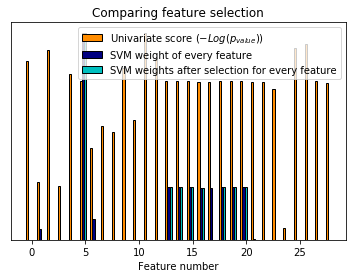

In [51]:
X_indices = np.arange(X_train.shape[-1])
from sklearn import datasets, svm
from sklearn.feature_selection import SelectPercentile, f_classif
selector = SelectPercentile(f_classif, percentile=60)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black')
print(scores)
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

svm_weights = (clf.coef_ ** 2).sum(axis=0)
svm_weights /= svm_weights.max()

plt.bar(X_indices - .25, svm_weights, width=.2, label='SVM weight of every feature',
        color='navy', edgecolor='black')

clf_selected = svm.SVC(kernel='linear')
clf_selected.fit(selector.transform(X_train), y_train)

svm_weights_selected = (clf_selected.coef_ ** 2).sum(axis=0)
svm_weights_selected /= svm_weights_selected.max()


plt.bar(X_indices[selector.get_support()] - .05, svm_weights_selected,
        width=.2, label='SVM weights after selection for every feature', color='c',
        edgecolor='black')


plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

/home/rishotics/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 39 members, which is too few. The minimum number of members in any class cannot be less than n_splits=45.
  % (min_groups, self.n_splits)), Warning)


0.4185185185185185
0.19123452805074942
0.4185185185185185
0.19123452805074942
0.4185185185185185
0.19123452805074942
0.4185185185185185
0.19123452805074942
0.4185185185185185
0.19123452805074942
0.4185185185185185
0.19123452805074942
0.4185185185185185
0.19123452805074942
0.4185185185185185
0.19123452805074942
0.4185185185185185
0.19123452805074942
0.4185185185185185
0.19123452805074942
0.4185185185185185
0.19123452805074942


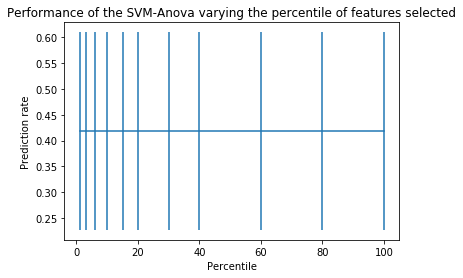

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
transform = SelectPercentile(f_classif)

clf = Pipeline([('anova', transform), ('svc', SVC(gamma="auto"))])

# #############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    # Compute cross-validation score using 1 CPU
    this_scores = cross_val_score(clf, X_train, y_train, cv=45, n_jobs=1)
    score_means.append(this_scores.mean())
    print(this_scores.mean())
    score_stds.append(this_scores.std())
    print(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))

plt.title(
    'Performance of the SVM-Anova varying the percentile of features selected')
plt.xlabel('Percentile')
plt.ylabel('Prediction rate')

plt.axis('tight')
plt.show()


[0.13342898 0.0918221  0.03730273 0.08751793 0.01649928 0.0107604
 0.01362984 0.05954089 0.02582496 0.01936872 0.10043041 0.03299857
 0.00502152 0.00215208 0.00215208 0.00502152 0.00143472 0.00860832
 0.01578192 0.00430416 0.0035868  0.00071736 0.         0.03156384
 0.03012913 0.0918221  0.06599713 0.06169297 0.04088953]


/home/rishotics/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


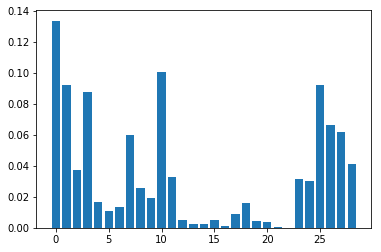

29

In [56]:
from xgboost import XGBClassifier
from matplotlib import pyplot
model = XGBClassifier()
model.fit(X_train, y_train)
model.score(X_test,y_test)
print(model.feature_importances_)
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()
len(model.feature_importances_)

In [57]:
from sklearn.feature_selection import SelectFromModel

from numpy import sort
model = svm.SVC(decision_function_shape='ovo')
thresholds = sort((model.feature_importances_))
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
    
	# train model
	selection_model = XGBClassifier()
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(X_test)
	y_pred = selection_model.predict(select_X_test)
	predictions = [round(value) for value in y_pred]
	accuracy = accuracy_score(y_test, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))


AttributeError: 'SVC' object has no attribute 'feature_importances_'

In [55]:
selection = SelectFromModel(model, threshold=0.010, prefit=True)
select_X_train = selection.transform(X_train)
select_X_test = selection.transform(X_test)
f=select_X_train.shape[1]
print(f)

ValueError: The underlying estimator SVC has no `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to SelectFromModel or call fit before calling transform.

In [24]:
lin_clf = svm.SVC(decision_function_shape='ovo')
lin_clf.fit(select_X_train,y_train) 



SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [ ]:
import pylab
pylab.scatter(select_X_train[:,8],select_X_train[:,20],c=train_labels)

In [25]:
lin_clf.predict(select_X_test)
100*lin_clf.score(select_X_test,y_test)

23.333333333333332

In [59]:
def Svm(thresh,select_X_train,y_train,select_X_test,y_test):
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    select_X_test = selection.transform(X_test)
    f=select_X_train.shape[1]
    print(f)
    x_vals= select_X_train
    from sklearn import datasets


    y_vals1 = np.array([1 if y==0 else -1 for y in y_train])
    y_vals2 = np.array([1 if y==1 else -1 for y in y_train])
    y_vals3 = np.array([1 if y==2 else -1 for y in y_train])
    y_vals = np.array([y_vals1, y_vals2, y_vals3])


    batch_size = 50
    sess = tf.Session()
    x_data = tf.placeholder(shape=[None,f], dtype=tf.float32)
    y_target = tf.placeholder(shape=[3, None], dtype=tf.float32)
    prediction_grid = tf.placeholder(shape=[None,f], dtype=tf.float32)
    b = tf.Variable(tf.random_normal(shape=[3,batch_size]))

    gamma = tf.constant(-7.0)
    dist = tf.reduce_sum(tf.square(x_data), 1)
    dist = tf.reshape(dist, [-1,1])
    sq_dists = tf.add(tf.subtract(dist, tf.multiply(2., tf.matmul(x_data,tf.transpose(x_data)))), tf.transpose(dist))
    my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))

    def reshape_matmul(mat):
        v1 = tf.expand_dims(mat, 1)
        v2 = tf.reshape(v1, [3, batch_size, 1])
        return(tf.matmul(v2, v1))
    
    model_output = tf.matmul(b, my_kernel)
    first_term = tf.reduce_sum(b)
    b_vec_cross = tf.matmul(tf.transpose(b), b)
    y_target_cross = reshape_matmul(y_target)
    second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross,y_target_cross)),[1,2])
    loss = tf.reduce_sum(tf.negative(tf.subtract(first_term, second_term)))

    rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1),[-1,1])
    rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1),[-1,1])
    pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data,tf.transpose(prediction_grid)))), tf.transpose(rB))
    pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

    prediction_output = tf.matmul(tf.multiply(y_target,b), pred_kernel)
    prediction = tf.arg_max(prediction_output-tf.expand_dims(tf.reduce_mean(prediction_output,1), 1), 0)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction,tf.argmax(y_target,0)), tf.float32))

    my_opt = tf.train.GradientDescentOptimizer(0.001)
    train_step = my_opt.minimize(loss)
    init = tf.initialize_all_variables()
    sess.run(init)

    loss_vec = []
    batch_accuracy = []
    for i in range(1000):
        rand_index = np.random.choice(len(x_vals), size=batch_size)
        X = x_vals[rand_index]
        Y = y_vals[:,rand_index]
    
        sess.run(train_step, feed_dict={x_data: X, y_target:Y})
        temp_loss = sess.run(loss, feed_dict={x_data: X, y_target: Y})
        loss_vec.append(temp_loss)
        acc_temp = sess.run(accuracy, feed_dict={x_data: X, y_target: Y, prediction_grid:X})
    
        batch_accuracy.append(acc_temp)
        if(acc_temp>0.1):
            print(acc_temp)

    plt.show(batch_accuracy)

In [60]:
from sklearn.feature_selection import SelectFromModel
from numpy import sort

thresholds = sort(model.feature_importances_)
for thresh in thresholds:
	# select features using threshold
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)
        select_X_test = selection.transform(X_test)
	# train model
        print("for thresh=")
        print(thresh)
        Svm(thresh,select_X_train,y_train,select_X_test,y_test)
    
	# eval model
	
	


AttributeError: 'SVC' object has no attribute 'feature_importances_'

In [26]:
clf = svm.SVC()

clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print(confidence)


0.23333333333333334


In [58]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=0.05,
                    hidden_layer_sizes=(1000,), random_state=1)

clf.fit(X_train, y_train)
clf.score(X_test,y_test)*100


70.0

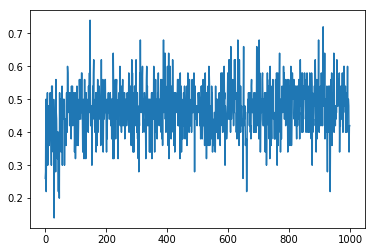

In [74]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(select_X_train,y_train)
class_predicted=neigh.predict(select_X_test)
print("KNN with 4 nearest neightbours")
print(" ")
print("score= ", 100*neigh.score(select_X_test, y_test, sample_weight=None))
from sklearn.metrics import confusion_matrix

CM = confusion_matrix(y_test, class_predicted)

print("confusion matrix=" )
print(CM)
from sklearn.metrics import precision_recall_fscore_support
print("precision,recall,fscore")
print("macro case =",precision_recall_fscore_support(y_test, class_predicted, average='macro'))
#print(sensitivity,specitivit
print("micro case=",precision_recall_fscore_support(y_test, class_predicted, average='micro'))
print("weighted case=",precision_recall_fscore_support(y_test, class_predicted, average='weighted'))


KNN with 4 nearest neightbours
 
('score= ', 66.66666666666666)
confusion matrix=
[[ 1  4  2]
 [ 2  7  0]
 [ 2  0 12]]
precision,recall,fscore
('macro case =', (0.5645021645021645, 0.5925925925925926, 0.5746031746031747, None))
('micro case=', (0.6666666666666666, 0.6666666666666666, 0.6666666666666666, None))
('weighted case=', (0.6375757575757576, 0.6666666666666666, 0.648888888888889, None))


In [76]:
print(select_X_test.shape)
print(select_X_train.shape)

(30, 19)
(130, 19)


In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(n_estimators=100, max_depth=10,
                             random_state=1)

clf.fit(select_X_train, y_train)
class_predicted=clf.predict(select_X_test)
print("RANDOM FOREST with no of estimators=100 and max depth=10")
print("score= ",100*clf.score(select_X_test,y_test))
CM = confusion_matrix(y_test, class_predicted)

print("confusion matrix=" )
print(CM)
from sklearn.metrics import precision_recall_fscore_support
print("precision,recall,fscore")
print("macro case =",precision_recall_fscore_support(y_test, class_predicted, average='macro'))
#print(sensitivity,specitivit
print("micro case=",precision_recall_fscore_support(y_test, class_predicted, average='micro'))
print("weighted case=",precision_recall_fscore_support(y_test, class_predicted, average='weighted'))


RANDOM FOREST with no of estimators=100 and max depth=10
('score= ', 80.0)
confusion matrix=
[[ 4  2  1]
 [ 1  8  0]
 [ 2  0 12]]
precision,recall,fscore
('macro case =', (0.7648351648351648, 0.7724867724867724, 0.7674742411584518, None))
('micro case=', (0.8, 0.8, 0.8000000000000002, None))
('weighted case=', (0.8041025641025641, 0.8, 0.8007797270955166, None))


In [65]:
# loop over the training images
